<a href="https://colab.research.google.com/github/ap12798/Applied_Deep_Learning/blob/main/Project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**This Applied Deep Learning Project will be to determine the stock trend of Deere (stock abrev DE) for the beginning of 2021. The notebook will make use of the library yfinance to access Deere's beginning day stock price for the past 10 years. Stacked LSTM, dropout, optimizers from**

In [ ]:
!pip install yfinance

     |████████████████████████████████| 6.3 MB 7.7 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23919 sha256=27864f469eb9282b0eed03ea2e9ec82ccb783192b8511d29325f4ced790f075a
  Stored in directory: /root/.cache/pip/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import time
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import statistics

Training Set and Test set. Test set isn't used until later.

In [ ]:
data_train = yf.download("DE", start="2010-01-01", end="2020-12-31") # defaults to one price per day
data_test = yf.download("DE", start="2021-01-01", end="2021-05-31")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


**Looking at the pandas output complete from yahoo, will trim down to just open price**

In [ ]:
data_train.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,54.740002,56.200001,54.340000,56.060001,43.838268,3974600
2010-01-05,56.189999,56.560001,55.599998,55.849998,43.674049,3007400
2010-01-06,55.570000,56.040001,55.220001,55.700001,43.556759,2854500
2010-01-07,55.380001,56.130001,55.169998,56.099998,43.869537,2694000
2010-01-08,55.779999,57.750000,55.299999,57.630001,45.065994,4165500


In [ ]:
data_train.shape, data_test.shape 

((2768, 6), (102, 6))

In [ ]:
train_set = data_train.iloc[:, 1:2].values # grabbing just the stock open price, iloc used to get right index for opening (creating a numpy array)
test_set = data_test.iloc[:, 1:2].values

In [ ]:
train_set

array([[ 56.20000076],
       [ 56.56000137],
       [ 56.04000092],
       ...,
       [273.55999756],
       [269.54000854],
       [268.35998535]])

In [ ]:
train_set.shape, test_set.shape

((2768, 1), (102, 1))

No handles with labels found to put in legend.


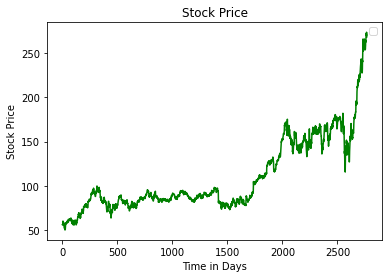

In [ ]:
plt.plot(train_set, color = 'green')
plt.title('Stock Price')
plt.xlabel('Time in Days')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [ ]:
# normalizing the test data
sc = MinMaxScaler() # defaults to zero and one
train_set_scaled = sc.fit_transform(train_set) # applying fit transform method to sc

**Taking a look at our new training set that is normalized from zero to one. Makes sense that the later values are closer to one after looking at the upward trend from above graph.**

In [ ]:
train_set_scaled

array([[0.02699316],
       [0.0286047 ],
       [0.02627693],
       ...,
       [1.        ],
       [0.98200462],
       [0.97672227]])

**At each time 't' the RNN will look at the 60 previous stock prices before time 't' and time 't' and based on the trend, try to predict the best output at t+1**

*Tried 30 timesteps and 90 timesteps and landed on 60 (3 months)being the best based on output**


In [ ]:
len(train_set)

2768

In [ ]:
X_train = [] # empty list that will be populated with the 60 previous stock prices and the next one
y_train = [] 
for i in range(60, 2768): #l en(train_set) # need to start at the 60th 
  X_train.append(train_set_scaled[i-60:i, 0]) # adding data to X_train (60 previous stock price before i'th day)
  y_train.append(train_set_scaled[i,0]) # adding data to y_train (time at t+1) - i because indexes start at zero
X_train = np.array(X_train) # convert list to numpy array
y_train = np.array(y_train) # convert list to numpy array

In [ ]:
X_train.shape

(2708, 60)

In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)) # reshaping data

In [ ]:
X_train.shape

(2708, 60, 1)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [ ]:
# hyperparameters
dropout = 0.2
neurons = 128
epochs = 16 # tried 50 and mean square error didn't do much after 16
batch_size = 32
optimizer = 'adam'
loss = 'mean_squared_error'

In [ ]:
model = Sequential()
model.add(LSTM(units = neurons, return_sequences = True, input_shape = (X_train.shape[1], 1)))
# model.add(LSTM(X_train.shape[2],input_shape = (X_train.shape[1],X_train.shape[2]),return_sequences = True,
                   # activation = 'relu')) for multivariate
model.add(Dropout(dropout))
model.add(LSTM(units = neurons, return_sequences = True))
model.add(Dropout(dropout))
model.add(LSTM(units = neurons, return_sequences = True))
model.add(Dropout(dropout))
model.add(LSTM(units = neurons))
model.add(Dropout(dropout))
model.add(Dense(1))

In [ ]:
model.compile(optimizer = optimizer, loss = loss)

In [ ]:
model.fit(X_train, y_train, epochs = epochs, batch_size = batch_size)

Epoch 1/16
85/85 [==============================] - 32s 287ms/step - loss: 0.0237
Epoch 2/16
85/85 [==============================] - 24s 285ms/step - loss: 0.0012
Epoch 3/16
85/85 [==============================] - 24s 284ms/step - loss: 0.0016
Epoch 4/16
85/85 [==============================] - 24s 287ms/step - loss: 0.0013
Epoch 5/16
85/85 [==============================] - 24s 287ms/step - loss: 0.0011
Epoch 6/16
85/85 [==============================] - 25s 289ms/step - loss: 0.0012
Epoch 7/16
85/85 [==============================] - 25s 289ms/step - loss: 0.0011
Epoch 8/16
85/85 [==============================] - 24s 285ms/step - loss: 0.0011
Epoch 9/16
85/85 [==============================] - 25s 288ms/step - loss: 0.0012
Epoch 10/16
85/85 [==============================] - 24s 286ms/step - loss: 9.6589e-04
Epoch 11/16
85/85 [==============================] - 25s 289ms/step - loss: 0.0011
Epoch 12/16
85/85 [==============================] - 25s 293ms/step - loss: 9.2049e-04
Epoch

In [ ]:
# need to get roughly 3 months (20 per month) 60 previous stock prices from the original data
# data_set_total = yf.download("DE", start = "2010-01-01", end = "2021-05-31")
# data_set_total = data_set_total['Open']

data_set_total = pd.concat((data_train['Open'], data_test['Open']), axis = 0)

In [ ]:
data_test.shape

(102, 6)

In [ ]:
inputs = data_set_total[len(data_set_total) - len(data_test) - 60:].values # using the previous 60 days to predict the 61st day
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs) # rnn is expecting this format
X_test = []
for i in range(60, 162): # 60 previous inputs + length of data_test (was 162 when 60)
  X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1)) # 3D structure for input

In [ ]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price) # going back from normalizing

In [ ]:
predicted_stock_price.shape

(102, 1)

In [ ]:
data_test.shape

(102, 6)

Chart below shows the actual stock price in green and predicted stock price in blue. No training data is displayed here.

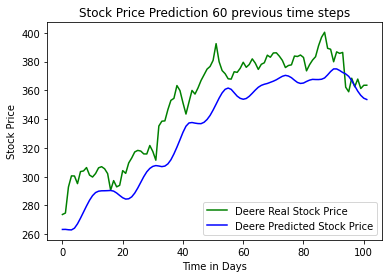

In [ ]:
plt.plot(test_set, color = 'green', label = 'Deere Real Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Deere Predicted Stock Price')
plt.title('Stock Price Prediction 60 previous time steps')
plt.xlabel('Time in Days')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [ ]:
# Function to calculate the percentage
def percent_error(a, b) :
 
    result = int(((b - a) * 100) / a)
 
    return result

In [ ]:
print(percent_error(predicted_stock_price[20],test_set[20]), "%")

6 %


In [ ]:
print(percent_error(predicted_stock_price[50],test_set[50]), "%")

9 %


In [ ]:
c = [abs(i-j)/i*100 for i,j in zip(predicted_stock_price,test_set)]
(sum(c)/len(c))[0]

5.824508422303811

**Below are simulations with different time steps**

* 30 time steps loss: 6.4616e-04
* 30 time steps accuracy: 17.2%
* 60 time steps loss: 7.7441e-04
* 60 time steps accuracy: 5.8%
* 90 time steps loss: 5.6209e-04
* 90 time steps accuracy: 8.2%


In [ ]:
X_train = [] # empty list that will be populated with the 60 previous stock prices and the next one
y_train = [] 
for i in range(30, 2768): #len(train_set) # need to start at the 60th 
  X_train.append(train_set_scaled[i-30:i, 0])
  y_train.append(train_set_scaled[i,0])
X_train = np.array(X_train)
y_train = np.array(y_train)

In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))

In [ ]:
# hyperparameters
dropout = 0.2
neurons = 128
epochs = 16 # tried 50 and mean square error didn't do much after 16
batch_size = 32
optimizer = 'adam'
loss = 'mean_squared_error'

In [ ]:
model = Sequential()
model.add(LSTM(units = neurons, return_sequences = True, input_shape = (X_train.shape[1], 1)))
# model.add(LSTM(X_train.shape[2],input_shape = (X_train.shape[1],X_train.shape[2]),return_sequences = True,
                   # activation = 'relu')) for multivariate
model.add(Dropout(dropout))
model.add(LSTM(units = neurons, return_sequences = True))
model.add(Dropout(dropout))
model.add(LSTM(units = neurons, return_sequences = True))
model.add(Dropout(dropout))
model.add(LSTM(units = neurons))
model.add(Dropout(dropout))
model.add(Dense(1))

In [ ]:
model.compile(optimizer = optimizer, loss = loss)

In [ ]:
model.fit(X_train, y_train, epochs = epochs, batch_size = batch_size)
data_set_total = pd.concat((data_train['Open'], data_test['Open']), axis = 0)

Epoch 1/16
86/86 [==============================] - 21s 156ms/step - loss: 0.0148
Epoch 2/16
86/86 [==============================] - 13s 155ms/step - loss: 0.0012
Epoch 3/16
86/86 [==============================] - 13s 152ms/step - loss: 0.0014
Epoch 4/16
86/86 [==============================] - 13s 154ms/step - loss: 0.0022
Epoch 5/16
86/86 [==============================] - 13s 154ms/step - loss: 0.0012
Epoch 6/16
86/86 [==============================] - 14s 161ms/step - loss: 0.0012
Epoch 7/16
86/86 [==============================] - 13s 155ms/step - loss: 0.0013
Epoch 8/16
86/86 [==============================] - 13s 153ms/step - loss: 0.0011
Epoch 9/16
86/86 [==============================] - 13s 155ms/step - loss: 9.1952e-04
Epoch 10/16
86/86 [==============================] - 13s 154ms/step - loss: 7.5290e-04
Epoch 11/16
86/86 [==============================] - 13s 154ms/step - loss: 7.2668e-04
Epoch 12/16
86/86 [==============================] - 13s 155ms/step - loss: 7.8254e-

In [ ]:
inputs = data_set_total[len(data_set_total) - len(data_test) - 30:].values # using the previous 60 days to predict the 61st day
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs) # rnn is expecting this format
X_test = []
for i in range(30, 132): # 30 previous inputs + length of data_test (was 162 when 60)
  X_test.append(inputs[i-30:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1)) # 3D structure for input

In [ ]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price) # going back from normalizing

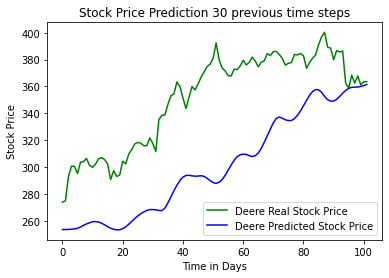

In [ ]:
plt.plot(test_set, color = 'green', label = 'Deere Real Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Deere Predicted Stock Price')
plt.title('Stock Price Prediction 30 previous time steps')
plt.xlabel('Time in Days')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [ ]:
print(percent_error(predicted_stock_price[20],test_set[20]), "%")

19 %


In [ ]:
print(percent_error(predicted_stock_price[50],test_set[50]), "%")

32 %


In [ ]:
c = [abs(i-j)/i*100 for i,j in zip(predicted_stock_price,test_set)]
(sum(c)/len(c))[0]

17.19789783066628

In [ ]:
X_train = [] # empty list that will be populated with the 60 previous stock prices and the next one
y_train = [] 
for i in range(90, 2768): #len(train_set) # need to start at the 60th 
  X_train.append(train_set_scaled[i-90:i, 0])
  y_train.append(train_set_scaled[i,0])
X_train = np.array(X_train)
y_train = np.array(y_train)

In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)) # reshaping data

In [ ]:
model = Sequential()
model.add(LSTM(units = neurons, return_sequences = True, input_shape = (X_train.shape[1], 1)))
# model.add(LSTM(X_train.shape[2],input_shape = (X_train.shape[1],X_train.shape[2]),return_sequences = True,
                   # activation = 'relu')) for multivariate
model.add(Dropout(dropout))
model.add(LSTM(units = neurons, return_sequences = True))
model.add(Dropout(dropout))
model.add(LSTM(units = neurons, return_sequences = True))
model.add(Dropout(dropout))
model.add(LSTM(units = neurons))
model.add(Dropout(dropout))
model.add(Dense(1))

In [ ]:
model.compile(optimizer = optimizer, loss = loss)

In [ ]:
model.fit(X_train, y_train, epochs = epochs, batch_size = batch_size)
data_set_total = pd.concat((data_train['Open'], data_test['Open']), axis = 0)

Epoch 1/16
84/84 [==============================] - 43s 429ms/step - loss: 0.0091
Epoch 2/16
84/84 [==============================] - 36s 428ms/step - loss: 0.0017
Epoch 3/16
84/84 [==============================] - 36s 432ms/step - loss: 0.0012
Epoch 4/16
84/84 [==============================] - 36s 427ms/step - loss: 0.0012
Epoch 5/16
84/84 [==============================] - 36s 426ms/step - loss: 0.0011
Epoch 6/16
84/84 [==============================] - 36s 429ms/step - loss: 0.0014
Epoch 7/16
84/84 [==============================] - 36s 428ms/step - loss: 0.0011
Epoch 8/16
84/84 [==============================] - 36s 432ms/step - loss: 0.0011
Epoch 9/16
84/84 [==============================] - 36s 427ms/step - loss: 0.0011
Epoch 10/16
84/84 [==============================] - 36s 426ms/step - loss: 7.6376e-04
Epoch 11/16
84/84 [==============================] - 36s 428ms/step - loss: 0.0010
Epoch 12/16
84/84 [==============================] - 36s 423ms/step - loss: 7.4130e-04
Epoch

In [ ]:
inputs = data_set_total[len(data_set_total) - len(data_test) - 90:].values # using the previous 60 days to predict the 61st day
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs) # rnn is expecting this format
X_test = []
for i in range(90, 192): # 30 previous inputs + length of data_test (was 162 when 60)
  X_test.append(inputs[i-90:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1)) # 3D structure for input

In [ ]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price) # going back from normalizing

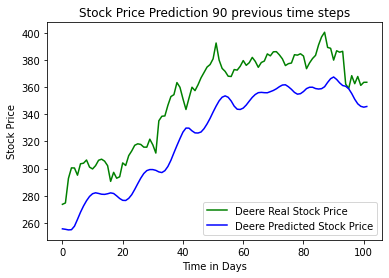

In [ ]:
plt.plot(test_set, color = 'green', label = 'Deere Real Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Deere Predicted Stock Price')
plt.title('Stock Price Prediction 90 previous time steps')
plt.xlabel('Time in Days')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [ ]:
print(percent_error(predicted_stock_price[20],test_set[20]), "%")

9 %


In [ ]:
print(percent_error(predicted_stock_price[50],test_set[50]), "%")

11 %


In [ ]:
c = [abs(i-j)/i*100 for i,j in zip(predicted_stock_price,test_set)]
(sum(c)/len(c))[0]

8.234717692181485